In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "6" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import matplotlib
import xgboost as xgb
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
np.random.seed(2)

In [4]:
complete_df = pd.read_csv("../data/local_no2_osm.csv")

In [5]:
complete_df.head()

,AirQualityStation,nature_osm_score,manmade_osm_score,road_distance_osm,StationType,AreaType,no2_average
0,STA.DE_DEBW087,0.911713,0.085162,1280.848977,background,rural-regional,7.242142
1,STA.DE_DEBB067,0.290766,0.559319,294.328252,background,suburban,13.814766
2,STA.DE_DEBB066,0.941288,0.000028,5131.708262,background,rural-regional,8.665383
3,STA.DE_DEBB065,1.000000,0.000000,4647.440530,background,rural-regional,9.190738
4,STA.DE_DEBB064,0.203717,0.483330,215.992108,background,urban,13.122752


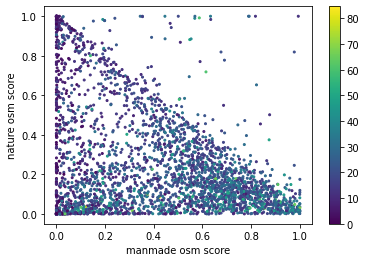

In [6]:
norm = matplotlib.colors.Normalize(vmin=complete_df.no2_average.min(), vmax=complete_df.no2_average.max())
cmap = cm.viridis

m = cm.ScalarMappable(norm=norm, cmap=cmap)

sc = plt.scatter(complete_df.manmade_osm_score, complete_df.nature_osm_score, s=4, c=m.to_rgba(complete_df.no2_average), cmap=m)
plt.colorbar(m)
plt.xlabel("manmade osm score")
plt.ylabel("nature osm score")
plt.show()

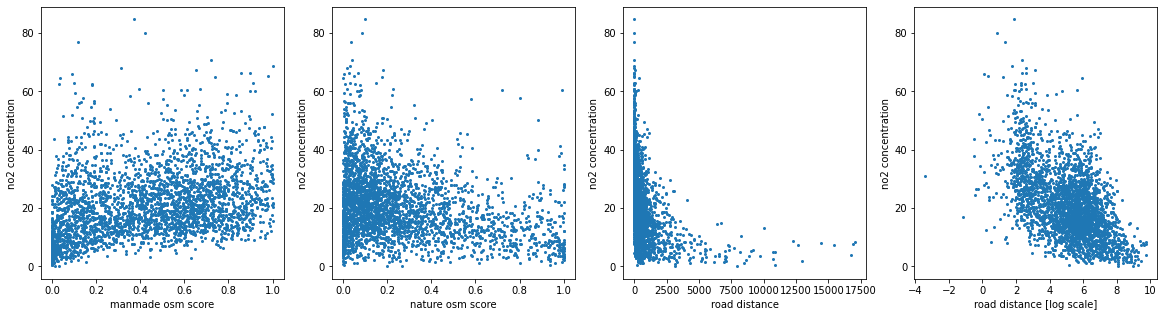

In [7]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))
ax.scatter(complete_df.manmade_osm_score, complete_df.no2_average, s=4)
ax.set_ylabel("no2 concentration")
ax.set_xlabel("manmade osm score")

ax1.scatter(complete_df.nature_osm_score, complete_df.no2_average, s=4)
ax1.set_ylabel("no2 concentration")
ax1.set_xlabel("nature osm score")

ax2.scatter(complete_df.road_distance_osm, complete_df.no2_average, s=4)
ax2.set_ylabel("no2 concentration")
ax2.set_xlabel("road distance")

ax3.scatter(np.log(complete_df.road_distance_osm.values), complete_df.no2_average, s=4)
ax3.set_ylabel("no2 concentration")
ax3.set_xlabel("road distance [log scale]")

plt.show()

In [8]:
scale_target = False
scale_inputs = False

scale_all = True

In [9]:
scaler = StandardScaler()
scaler_target = StandardScaler()
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()
val_scaler = MinMaxScaler()

scaler_road = StandardScaler()
train_scaler_road = StandardScaler()
test_scaler_road = StandardScaler()
val_scaler_road = StandardScaler()

train_scaler_manmade = StandardScaler()
test_scaler_manmade = StandardScaler()
val_scaler_manmade = StandardScaler()

train_scaler_nature = StandardScaler()
test_scaler_nature = StandardScaler()
val_scaler_nature = StandardScaler()

In [10]:
# scale inputs (all with one scaler)

if scale_all:
    complete_df[["nature_osm_score_scaled", "manmade_osm_score_scaled", "road_distance_osm_scaled"]] = pd.DataFrame(scaler.fit_transform(complete_df[["nature_osm_score", "manmade_osm_score", "road_distance_osm"]]))
    complete_df["no2_average_scaled"] = scaler_target.fit_transform(complete_df["no2_average"].values.reshape(-1,1))
    
    train, test = train_test_split(complete_df, test_size=0.4)
    test, val = train_test_split(test, test_size=0.5)

    train_data = xgb.DMatrix(data=train[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=train.no2_average_scaled)
    test_data = xgb.DMatrix(data=test[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=test.no2_average_scaled)
    val_data = xgb.DMatrix(data=val[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=val.no2_average_scaled) 

In [11]:
if not scale_all:
    train, test = train_test_split(complete_df, test_size=0.3)
    test, val = train_test_split(test, test_size=0.5)

    data = xgb.DMatrix(data=complete_df[["manmade_osm_score", "nature_osm_score", "road_distance_osm"]], label=complete_df.no2_average)

    if scale_inputs:
        train["road_distance_osm_scaled"] = train_scaler_road.fit_transform(np.array(train.loc[:, "road_distance_osm"]).reshape(-1,1))
        test["road_distance_osm_scaled"] = test_scaler_road.fit_transform(np.array(test.loc[:, "road_distance_osm"]).reshape(-1,1))
        val["road_distance_osm_scaled"] = val_scaler_road.fit_transform(np.array(val.loc[:, "road_distance_osm"]).reshape(-1,1))

        train["nature_osm_score_scaled"] = train_scaler_nature.fit_transform(np.array(train.loc[:, "nature_osm_score"]).reshape(-1,1))
        test["nature_osm_score_scaled"] = test_scaler_nature.fit_transform(np.array(test.loc[:, "nature_osm_score"]).reshape(-1,1))
        val["nature_osm_score_scaled"] = val_scaler_nature.fit_transform(np.array(val.loc[:, "nature_osm_score"]).reshape(-1,1))

        train["manmade_osm_score_scaled"] = train_scaler_manmade.fit_transform(np.array(train.loc[:, "manmade_osm_score"]).reshape(-1,1))
        test["manmade_osm_score_scaled"] = test_scaler_manmade.fit_transform(np.array(test.loc[:, "manmade_osm_score"]).reshape(-1,1))
        val["manmade_osm_score_scaled"] = val_scaler_manmade.fit_transform(np.array(val.loc[:, "manmade_osm_score"]).reshape(-1,1))


    if scale_target and scale_inputs:
        train_data = xgb.DMatrix(data=train[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=train_scaler.fit_transform(np.array(train.no2_average).reshape(-1,1)))
        test_data = xgb.DMatrix(data=test[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=test_scaler.fit_transform(np.array(test.no2_average).reshape(-1,1)))
        val_data = xgb.DMatrix(data=val[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], label=val_scaler.fit_transform(np.array(val.no2_average).reshape(-1,1)))

    elif scale_target:
        train_data = xgb.DMatrix(data=train[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=train_scaler.fit_transform(np.array(train.no2_average).reshape(-1,1)))
        test_data = xgb.DMatrix(data=test[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=test_scaler.fit_transform(np.array(test.no2_average).reshape(-1,1)))
        val_data = xgb.DMatrix(data=val[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=val_scaler.fit_transform(np.array(val.no2_average).reshape(-1,1)))

    else:
        train_data = xgb.DMatrix(data=train[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=train.no2_average)
        test_data = xgb.DMatrix(data=test[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=test.no2_average)
        val_data = xgb.DMatrix(data=val[["manmade_osm_score", "nature_osm_score", "road_distance_osm_scaled"]], label=val.no2_average)

In [12]:
param = {'max_depth': 8,
         'eta': 0.4,
         'gamma' : 10,
         #'subsample' : 0.8,
         'objective': 'reg:squarederror',
        }

param ={'eta': 0.5,
 'gamma': 10,
 'max_depth': 6,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [13]:
num_round = 50

#bst = xgb.train(param, train_data, num_round, evals=[(val_data, "validation")], early_stopping_rounds=5)

bst = xgb.train(param, train_data, num_round)

In [14]:
if scale_all:
    ypred = scaler_target.inverse_transform(bst.predict(test_data).reshape(-1,1))
    ypred_train = scaler_target.inverse_transform(bst.predict(train_data).reshape(-1, 1))
    ypred_val = scaler_target.inverse_transform(bst.predict(val_data).reshape(-1, 1))
   # ypred = scaler.inverse_transform()

elif scale_target:
    ypred = test_scaler.inverse_transform(np.array(bst.predict(test_data)).reshape(-1,1))
    ypred_train = train_scaler.inverse_transform(np.array(bst.predict(train_data)).reshape(-1,1))
    ypred_val = val_scaler.inverse_transform(np.array(bst.predict(val_data)).reshape(-1,1))
    
else:
    ypred = bst.predict(test_data)
    ypred_train = bst.predict(train_data)
    ypred_val = bst.predict(val_data)

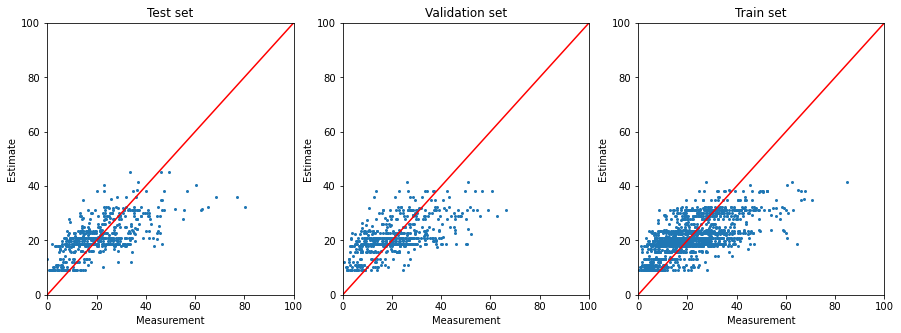

In [15]:
fig, (axl, axm, axr) = plt.subplots(1, 3, figsize=(15, 5))

axl.scatter(test.no2_average, ypred, s=4)
axl.plot((0, 100),(0, 100), c="red")
axl.set_xlim((0, 100))
axl.set_ylim((0, 100))
axl.set_title("Test set")
axl.set_xlabel("Measurement")
axl.set_ylabel("Estimate")

axm.scatter(val.no2_average, ypred_val, s=4)
axm.plot((0, 100),(0,100), c="red")
axm.set_xlim((0, 100))
axm.set_ylim((0, 100))
axm.set_title("Validation set")
axm.set_xlabel("Measurement")
axm.set_ylabel("Estimate")

axr.scatter(train.no2_average, ypred_train, s=4)
axr.plot((0,100),(0, 100), c="red")
axr.set_xlim((0, 100))
axr.set_ylim((0, 100))
axr.set_title("Train set")
axr.set_xlabel("Measurement")
axr.set_ylabel("Estimate")
plt.show()

In [16]:
bst.get_score(importance_type="gain")

{'road_distance_osm_scaled': 66.63691323,
 'nature_osm_score_scaled': 14.608657302222221,
 'manmade_osm_score_scaled': 49.721608675}

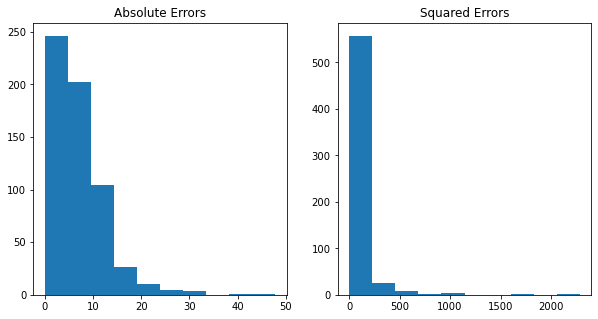

In [17]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax.hist(abs(test.no2_average - ypred.squeeze()), bins=10)
ax.set_title("Absolute Errors")
ax1.hist((test.no2_average - ypred.squeeze())**2, bins=10)
ax1.set_title("Squared Errors")
plt.show()

In [18]:
"val:", r2_score(val.no2_average, ypred_val), mean_squared_error(val.no2_average, ypred_val), mean_absolute_error(val.no2_average, ypred_val)

('val:', 0.3535694011587055, 90.24898168063606, 7.406024759657692)

In [19]:
"test:", r2_score(test.no2_average, ypred), mean_squared_error(test.no2_average, ypred), mean_absolute_error(test.no2_average, ypred)

('test:', 0.40944226227987524, 82.87968381854576, 7.008758459764044)

In [20]:
"train:", r2_score(train.no2_average, ypred_train), mean_squared_error(train.no2_average, ypred_train), mean_absolute_error(train.no2_average, ypred_train)

('train:', 0.3997352832736374, 79.71260653422966, 6.9138447592105)

In [21]:
test_data = np.array([test.no2_average.values.squeeze(), ypred.squeeze()])
train_data = np.array([train.no2_average.values.squeeze(), ypred_train.squeeze()])

In [37]:
# save predictions
np.save(f"../data_figures/test_OSM_whole_timespan.npy", test_data)
np.save(f"../data_figures/train_OSM_whole_timespan.npy", train_data)

In [30]:
# save the model, its init parameters and the corresponding scalers
model_time = str(datetime.datetime.today()).replace(" ", "_").split(".")[0]

bst.save_model(os.path.join("osm_models", model_time+"_osm_baseline_model.json"))

with open(os.path.join("osm_models", model_time+"_params.json"), "w") as f:
    json.dump(param, f)

joblib.dump(test_scaler_road, os.path.join("osm_models", model_time+"_street_dist_scaler.save"))
joblib.dump(test_scaler, os.path.join("osm_models", model_time+"_no2_average_scaler.save"))

NameError: name 'datetime' is not defined

# CV

In [22]:
param_grid = {'max_depth': [4,5,6,8],#[,
         'eta': [0.4, 0.5, 0.6],# 0.1, 0.3, 0.4, 0.5, 0.8, 0.9, 0.99],
         'gamma' : [0, 1, 5, 10, 20, 30],# 0.2, 0.5, 0.8, 0.9, 0.99],
         'subsample' : [0.6, 0.7, 0.8, 0.9, 1],
         'objective': ['reg:squarederror'],#, 'reg:squaredlogerror', "reg:pseudohubererror"],
        # "tree_method" : ["hist"],
        }

In [23]:
xg = xgb.XGBRegressor()
best_xgb = GridSearchCV(xg, param_grid=param_grid, cv=5, verbose=1)

In [24]:
best_xgb

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [25]:
#complete_df["road_distance_osm_scaled"] = scaler.fit_transform(np.array(complete_df.road_distance_osm).reshape(-1,1))

best_xgb.fit(complete_df[["manmade_osm_score_scaled", "nature_osm_score_scaled", "road_distance_osm_scaled"]], complete_df["no2_average_scaled"])

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  2.7min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [26]:
#best_xgb.cv_results_
best_idx = best_xgb.cv_results_["rank_test_score"].argmin()
best_params = best_xgb.cv_results_["params"][best_idx]
best_score = best_xgb.cv_results_["mean_test_score"][best_idx]
best_score_std = best_xgb.cv_results_["std_test_score"][best_idx]

In [27]:
print(best_score, "+-", best_score_std)

0.3392364849192405 +- 0.08908434875483551


In [28]:
best_params

{'eta': 0.5,
 'gamma': 10,
 'max_depth': 6,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [ ]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.stock_img()

ax.set_extent((-15,30,30,70))
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)


ax.scatter(data.SurfaceLongitude, data.SurfaceLatitude,
         color='green', s=2, marker=",",
         transform=ccrs.PlateCarree(),
         )
#ax.coastlines()
plt.show()

#plt.savefig("figures/eea_stations_europe.pdf", dpi=100)